In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import PolyLine
from branca.colormap import LinearColormap
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN


# 1. 직접 유동인구 만들기

In [136]:
df_yong = pd.read_csv('용인시_OD데이터.csv')
df_po = pd.read_csv('포천시_OD데이터.csv')

In [137]:
df_yong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540616 entries, 0 to 540615
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   출발_도착       540616 non-null  object 
 1   ETL_YMD     540616 non-null  int64  
 2   CNT         540616 non-null  float64
 3   O_ADMI_CD   540616 non-null  int64  
 4   O_ADMI_NM   540616 non-null  object 
 5   O_CENTER_X  540616 non-null  int64  
 6   O_CENTER_Y  540616 non-null  int64  
 7   D_ADMI_CD   540616 non-null  int64  
 8   D_ADMI_NM   540616 non-null  object 
 9   D_CENTER_X  540616 non-null  int64  
 10  D_CENTER_Y  540616 non-null  int64  
 11  출발_경도       540616 non-null  float64
 12  출발_위도       540616 non-null  float64
 13  도착_경도       540616 non-null  float64
 14  도착_위도       540616 non-null  float64
dtypes: float64(5), int64(7), object(3)
memory usage: 61.9+ MB


# O-D 쌍클러스터링

## 1-1. 요일 만들기

In [138]:
# 숫자형 > 문자형 > 날짜형태 > 요일
df_yong['ETL_YMD'] = df_yong['ETL_YMD'].astype(str)
df_yong['ETL_YMD'] = pd.to_datetime(df_yong['ETL_YMD'])
df_yong['요일'] = df_yong['ETL_YMD'].apply(lambda x: x.weekday())

df_po['ETL_YMD'] = df_po['ETL_YMD'].astype(str)
df_po['ETL_YMD'] = pd.to_datetime(df_po['ETL_YMD'])
df_po['요일'] = df_po['ETL_YMD'].apply(lambda x: x.weekday())

## 1-2. 요일 별, 출발도착지 별 CNT

In [139]:
agg_func = {'CNT':'sum','출발_경도':'mean','출발_위도':'mean','도착_경도':'mean','도착_위도':'mean'}
route_cnt = df_yong.groupby(['출발_도착']).agg(agg_func).sort_values(by='CNT',ascending=False)

In [140]:
cnt_max = np.max(route_cnt['CNT'])
cnt_min = np.min(route_cnt['CNT'])

route_cnt['st_CNT'] = route_cnt['CNT'].apply(lambda x : (x-cnt_min)/(cnt_max-cnt_min))

In [141]:
route_cnt.head(20)

,CNT,출발_경도,출발_위도,도착_경도,도착_위도,st_CNT
출발_도착,,,,,,
신봉동-성복동,186407.51,127.057862,37.332254,127.060544,37.319338,1.000000
성복동-신봉동,179747.19,127.060544,37.319338,127.057862,37.332254,0.964257
풍덕천1동-동천동,159623.46,127.093476,37.327964,127.057418,37.350162,0.856262
마북동-구성동,152249.04,127.127388,37.306704,127.141321,37.295390,0.816687
동천동-풍덕천1동,151986.27,127.057418,37.350162,127.093476,37.327964,0.815277
구성동-마북동,148554.65,127.141321,37.295390,127.127388,37.306704,0.796861
중앙동-역북동,140852.97,127.200586,37.224984,127.186338,37.241208,0.755529
구갈동-신갈동,136688.23,127.123111,37.277332,127.101457,37.283102,0.733179
역북동-중앙동,135828.00,127.186338,37.241208,127.200586,37.224984,0.728563


In [142]:
colormap = LinearColormap(['red', 'green'], vmin=-1, vmax=1)

m = folium.Map(location=[37.332254, 127.057862], zoom_start=20)

for idx,route in route_cnt.iterrows():
    # CNT에 따라 투명도 조절 (선의 진한 정도)
    opacity = route['st_CNT']
    # 선의 색상 선택
    color = colormap(route['st_CNT'])
    
    # 경로 그리기
    folium.PolyLine(
        [(route['출발_위도'],route['출발_경도']),(route['도착_위도'],route['도착_경도'])], 
        color=color, 
        weight=5,  # 선의 두께
        opacity=opacity
    ).add_to(m)


In [143]:
m

In [156]:
# 0: 월요일, 1: 화요일 ... , 6:토요일, 7:일요일
yong_week_cnt = df_yong[['출발_도착','요일','CNT']].groupby(['출발_도착','요일']).sum('CNT').sort_values(by=['CNT'],ascending=False)

In [173]:
yong_cnt = df_yong[['출발_도착','CNT']].groupby(['출발_도착']).sum('CNT').sort_values(by=['CNT'],ascending=False)
yong_cnt = yong_cnt[yong_cnt['CNT'] >= 25000]

In [175]:
yong_cnt_idx = yong_cnt.index.to_list()

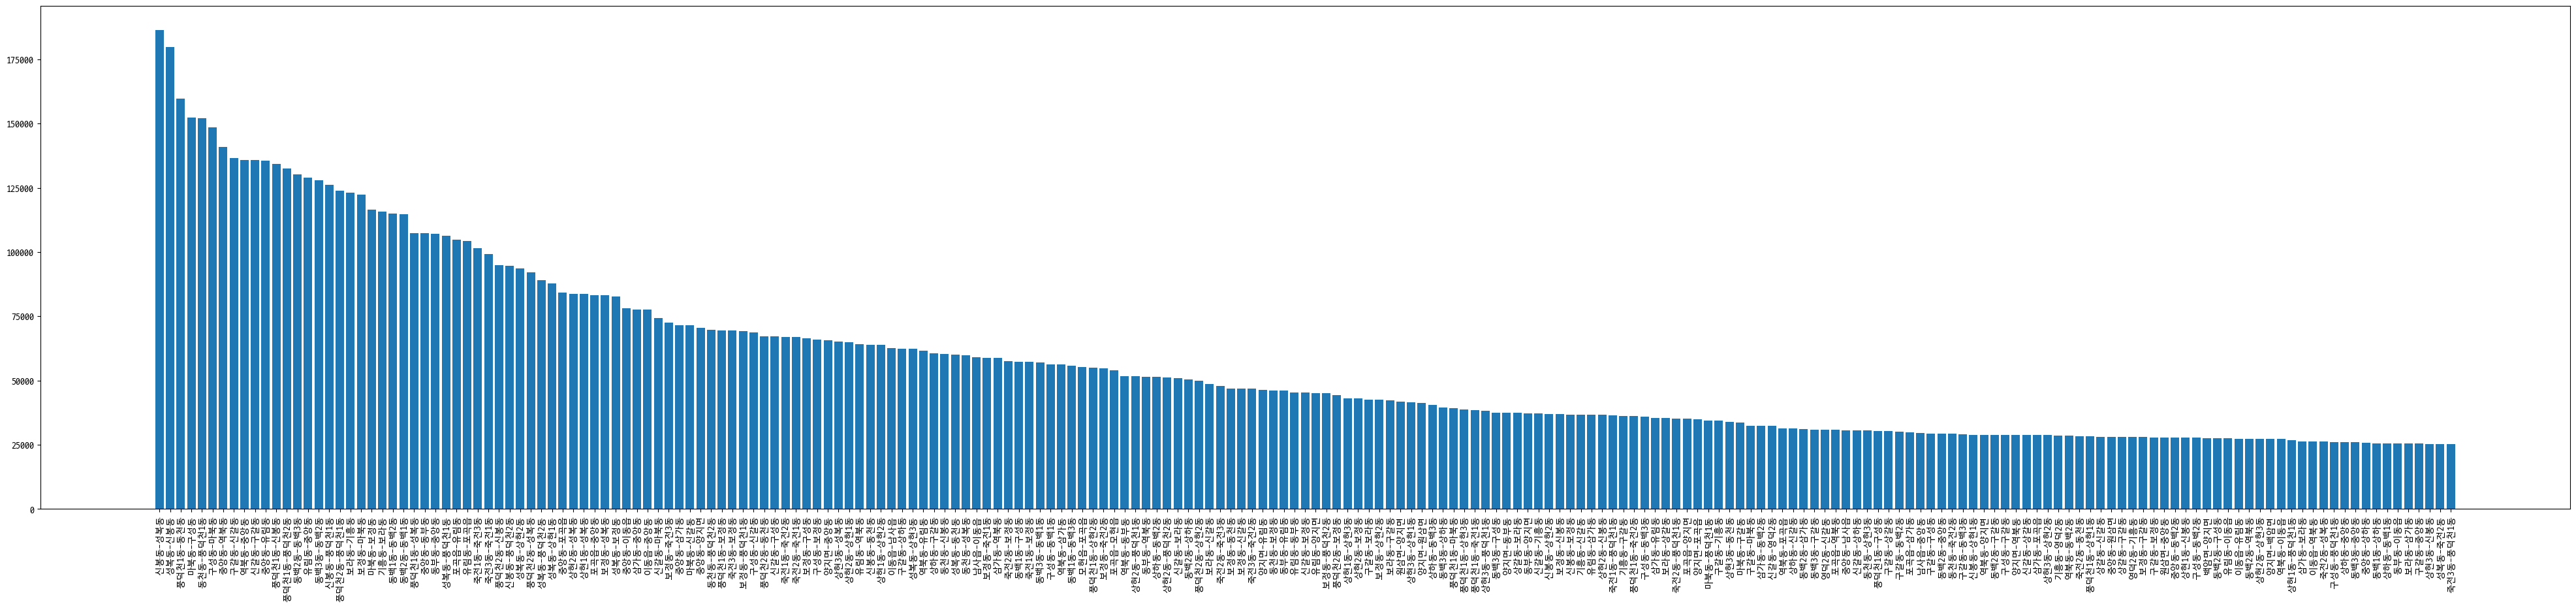

In [176]:
plt.figure(figsize=(50,10))
plt.bar(yong_cnt_idx,yong_cnt['CNT'])

plt.xticks(rotation = 90)
plt.show()

1406

In [89]:
od_pairs = route_cnt[['출발_위도','출발_경도','도착_위도','도착_경도']].values
od_pairs

array([[ 37.33225354, 127.05786167,  37.31933766, 127.06054447],
       [ 37.31933766, 127.06054447,  37.33225354, 127.05786167],
       [ 37.32796448, 127.09347648,  37.35016238, 127.05741794],
       ...,
       [ 37.23268223, 127.07917545,  37.32513938, 127.12509572],
       [ 37.1437142 , 127.37969599,  37.30698113, 127.07829908],
       [ 37.23268223, 127.07917545,  37.30698113, 127.07829908]])

In [90]:
demands = route_cnt['CNT'].values
demands

array([1.8640751e+05, 1.7974719e+05, 1.5962346e+05, ..., 1.1799000e+02,
       1.1701000e+02, 6.7950000e+01])

# 유입인구

In [1]:
import pandas as pd

df_po_out = pd.read_csv("GG_TRANS_SEXAGE_ADMI_INFLOW_202404_4165_포천시.csv")
df_po_in = pd.read_csv("GG_TRANS_SEXAGE_ADMI_OUTFLOW_202404_4165_포천시.csv")

In [2]:
df_po_in = df_po_in[df_po_in['AGE_GRP'] >= 8]
df_po_out = df_po_out[df_po_out['AGE_GRP'] >= 8]

In [3]:
df_po_in

,ETL_YMD,O_TIME_CD,O_ADMI_CD,O_MEGA_NM,O_CTY_NM,O_ADMI_NM,O_CENTER_X,O_CENTER_Y,TRANS_GB,SEX_CD,AGE_GRP,CNT
1,20240412,8,41650310,경기도,포천시,군내면,976212,1986424,3,M,9,4.37
7,20240408,19,41650250,경기도,포천시,소흘읍,969098,1977238,3,W,8,30.51
32,20240405,18,41650510,경기도,포천시,포천동,972030,1988320,0,M,8,48.55
36,20240418,10,41650350,경기도,포천시,창수면,971642,2002595,1,M,9,4.26
42,20240405,19,41650510,경기도,포천시,포천동,972030,1988320,0,W,8,7.82
...,...,...,...,...,...,...,...,...,...,...,...,...
329634,20240409,21,41650330,경기도,포천시,가산면,973695,1981610,3,W,9,4.50
329638,20240408,23,41650330,경기도,포천시,가산면,973695,1981610,3,M,8,6.77
329643,20240419,21,41650320,경기도,포천시,내촌면,976694,1977577,0,M,8,3.52
329644,20240419,8,41650320,경기도,포천시,내촌면,976694,1977577,0,M,9,3.49


In [8]:
df_po_in_group = df_po_in.groupby(['O_ADMI_CD','O_TIME_CD']).agg({"CNT":"sum"})
df_po_in_group = pd.pivot_table(df_po_in_group, index = 'O_ADMI_CD', columns='O_TIME_CD', values = 'CNT')
df_po_in_group

O_TIME_CD,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
O_ADMI_CD,,,,,,,,,,,,,,,,,,,,,
41650250,802.01,1871.23,1678.46,1285.82,2184.60,4360.99,6869.66,7974.48,8525.28,8484.50,...,13288.51,12822.89,11445.90,9889.24,7298.17,5878.23,4136.10,3107.57,2382.08,1114.23
41650310,149.73,356.92,329.56,289.61,473.73,991.52,1580.79,1949.49,2562.73,2271.43,...,2016.58,2051.41,1720.83,1872.29,1815.69,1322.34,896.20,681.80,425.91,332.63
41650320,43.00,151.77,76.65,117.97,344.46,447.50,739.50,1344.12,1598.39,1373.08,...,2762.66,2428.75,2392.85,2080.49,1935.14,1071.91,567.42,322.48,285.59,303.64
41650330,144.83,327.81,306.78,317.76,493.80,873.39,1233.23,1683.22,2160.48,2114.52,...,2200.15,2509.80,3081.94,3318.55,2248.47,1198.43,624.52,687.64,354.28,256.57
41650340,136.82,323.45,241.14,276.95,543.96,1011.08,1760.20,2637.46,3299.25,3591.94,...,5272.95,5641.70,5107.31,4125.12,2600.87,1784.64,1125.80,806.67,456.00,186.50
41650350,31.96,44.80,30.46,35.36,73.59,190.40,414.47,500.62,947.51,815.84,...,841.72,775.11,728.20,648.10,455.26,252.51,132.20,67.05,50.32,75.41
41650360,104.65,196.31,177.65,225.44,259.31,511.07,871.46,997.37,1421.62,1407.04,...,1645.83,1185.04,1410.69,1255.32,1030.98,688.65,439.03,393.15,304.82,167.40
41650370,97.59,339.33,226.10,344.44,378.96,2033.28,2782.54,2211.98,2553.76,2340.33,...,3011.40,3006.26,2890.08,2512.57,1909.34,1207.38,867.25,619.54,414.01,189.60
41650380,90.77,266.60,199.07,159.65,233.20,677.38,1118.10,1594.35,1551.36,1568.97,...,4172.43,2524.59,1785.83,1295.90,1208.02,1175.90,701.24,349.99,193.13,209.58


In [21]:
df_po_in_group_idx =  df_po_in_group.index.to_list()
df_po_in_group_idx

[41650250,
 41650310,
 41650320,
 41650330,
 41650340,
 41650350,
 41650360,
 41650370,
 41650380,
 41650390,
 41650400,
 41650410,
 41650510,
 41650520]

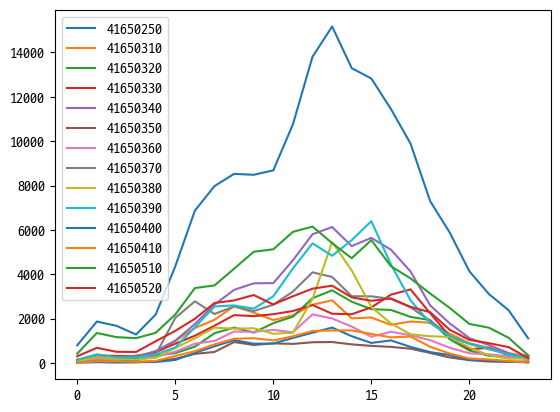

In [22]:
for i, row in df_po_in_group.iterrows():
    plt.plot(row)
    plt.legend(df_po_in_group_idx)

In [128]:
ADMI_CD= df_po_in.O_ADMI_CD.value_counts().index.to_list()

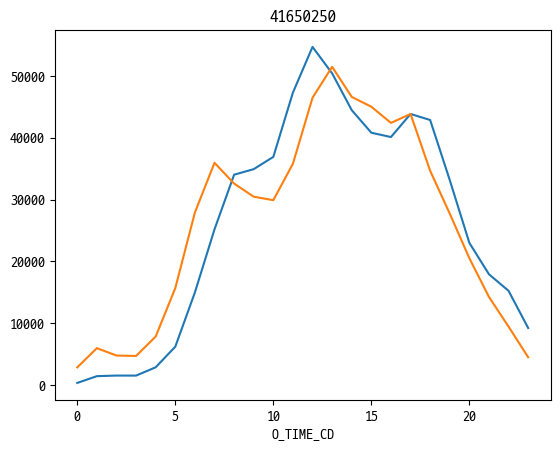

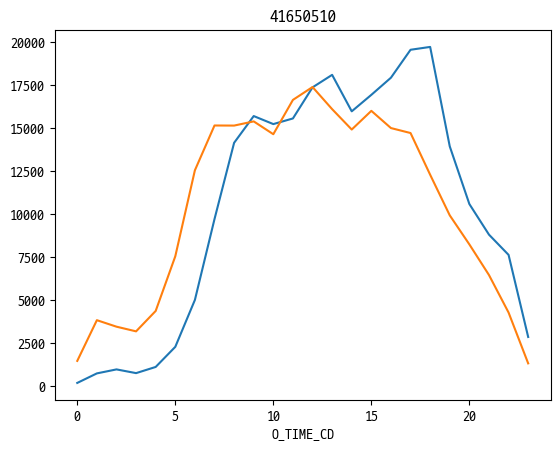

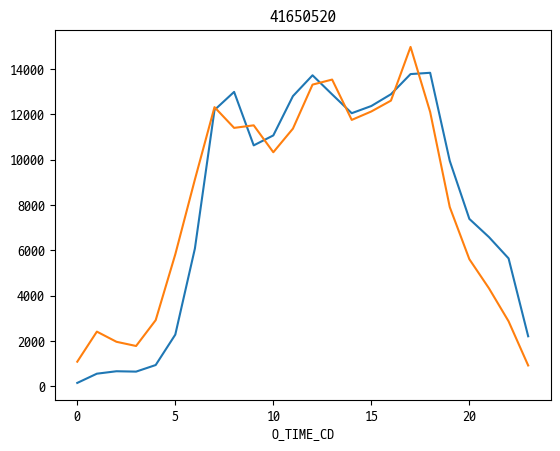

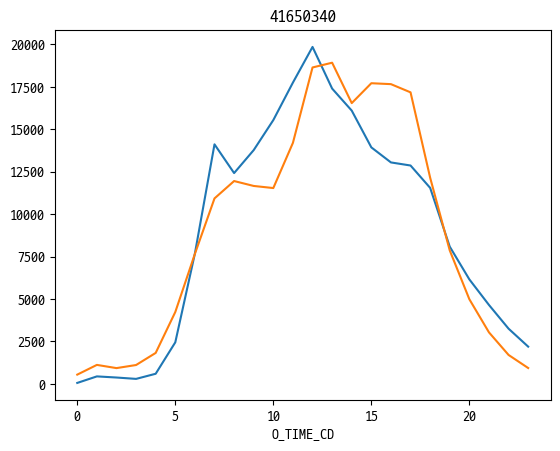

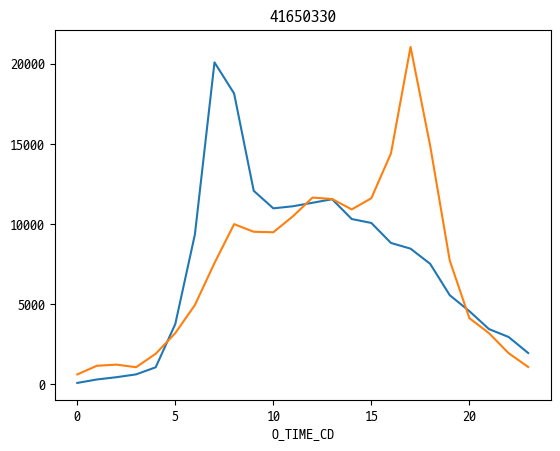

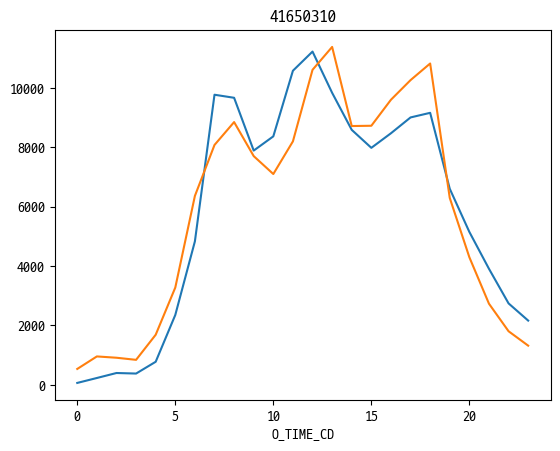

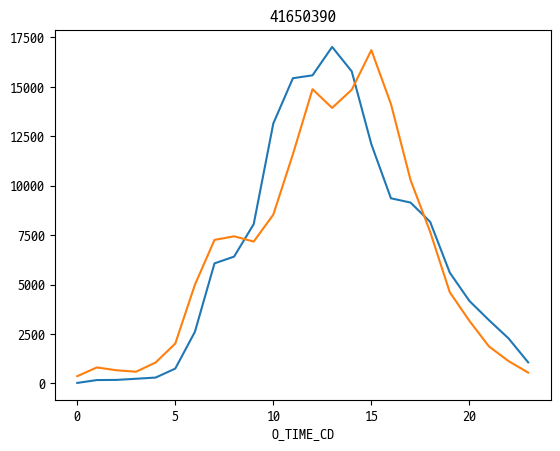

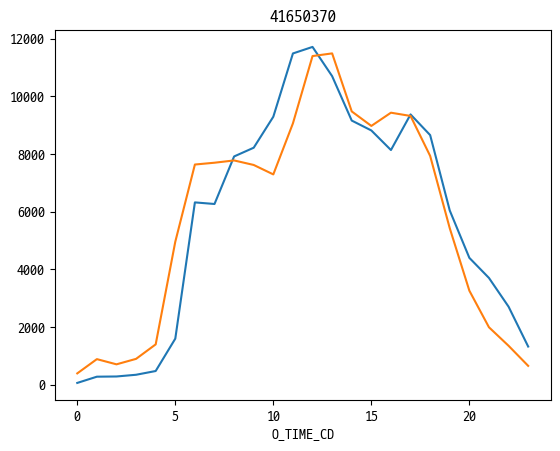

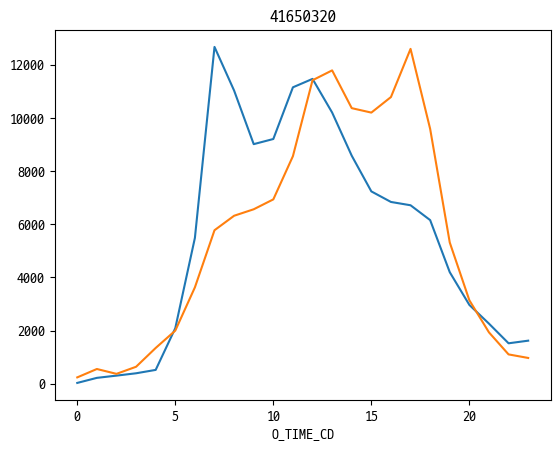

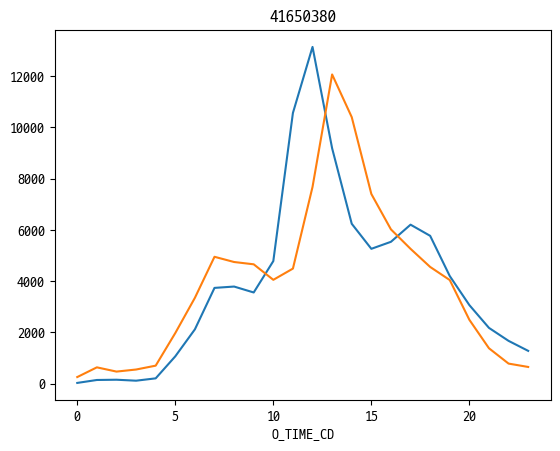

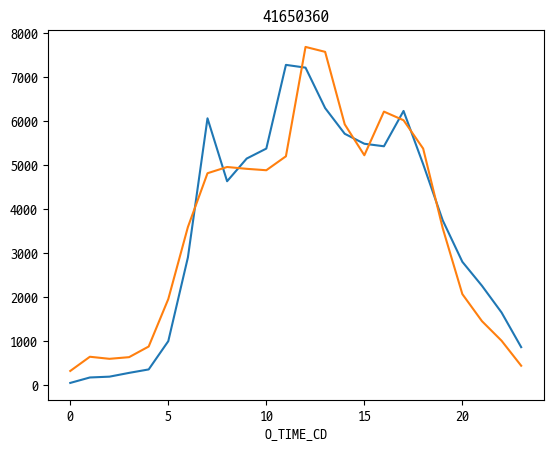

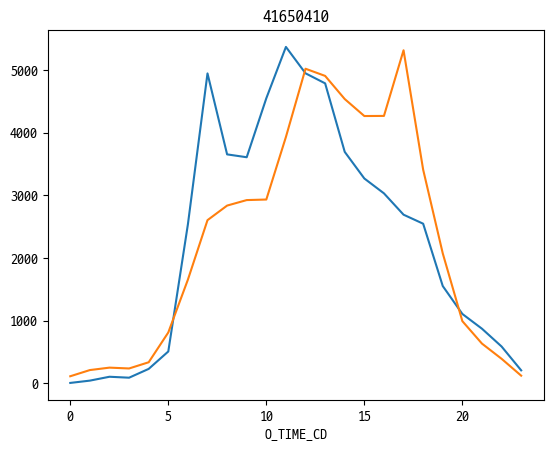

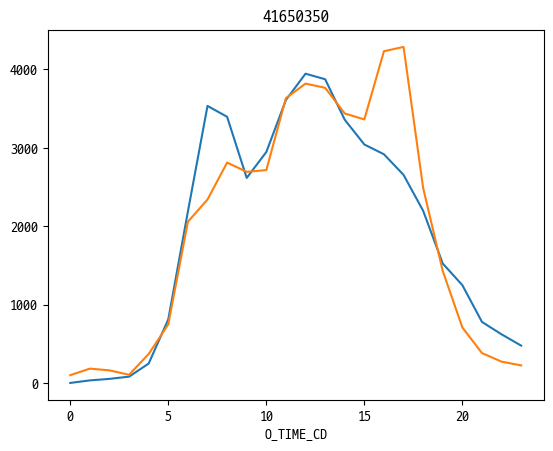

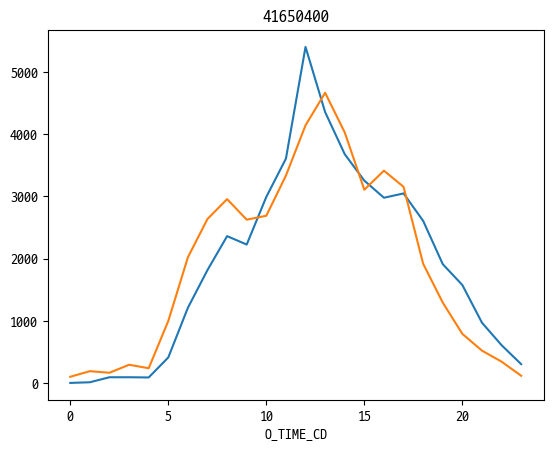

In [134]:
for i in ADMI_CD:
    one_in = df_po_in[df_po_in['O_ADMI_CD'] == i]
    one_out = df_po_out[df_po_out['D_ADMI_CD'] == i]
    one_out.groupby(['D_TIME_CD']).CNT.sum().plot()
    one_in.groupby(['O_TIME_CD']).CNT.sum().plot()
    
    plt.title(i)
    plt.show()

In [107]:
one_in = df_po_in[df_po_in['O_ADMI_CD'] == 41650250]

In [111]:
one_out = df_po_out[df_po_out['D_ADMI_CD'] == 41650250]

<Axes: xlabel='O_TIME_CD'>

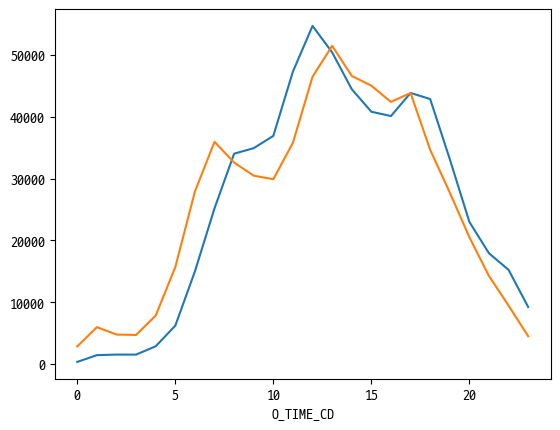

In [113]:
one_out.groupby(['D_TIME_CD']).CNT.sum().plot()
one_in.groupby(['O_TIME_CD']).CNT.sum().plot()